In [2]:
# Loading the Boston housing dataset
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Checking out the data
print(train_data.shape)
print(train_targets.shape)

(404, 13)
(404,)


In [4]:
# Feature-wise normalization
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std
print(train_data[:3])

[[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
   0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
   0.8252202 ]
 [-0.40342651  2.99178419 -1.33391162 -0.25683275 -1.21518188  1.89434613
  -1.91036058  1.24758524 -0.85646254 -0.34843254 -1.71818909  0.43190599
  -1.32920239]
 [ 0.1249402  -0.48361547  1.0283258  -0.25683275  0.62864202 -1.82968811
   1.11048828 -1.18743907  1.67588577  1.5652875   0.78447637  0.22061726
  -1.30850006]]


In [5]:
# Setting the model
from keras import models
from keras import layers

def build_model(units=[64,64]):
    model = models.Sequential()
    for unit_number in units:
        model.add(layers.Dense(unit_number, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(1))
    model.compile( optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

test_model = build_model()
print(test_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# Implementing K-fold
import numpy as np
k = 4
num_val_samples = len(train_data)//4
num_epochs = 200
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i *num_val_samples], train_data[(i + 1) * num_val_samples:]],
        axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i *num_val_samples], train_targets[(i + 1) * num_val_samples:]],
        axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 0,
                       validation_data=(val_data, val_targets))
    mae_history = history.history['val_mean_absolute_error']
    all_scores.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [18]:
avarage_mae_history = [ np.mean([x[i] for x in all_scores]) for i in range(num_epochs) ]

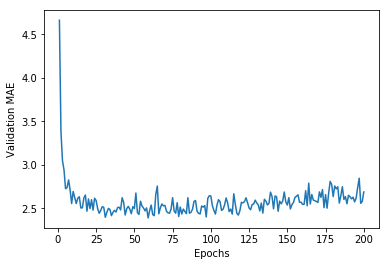

In [19]:
# Ploting results
import matplotlib.pyplot as plt
plt.clf()
plt.plot(range(1, len(avarage_mae_history) + 1), avarage_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

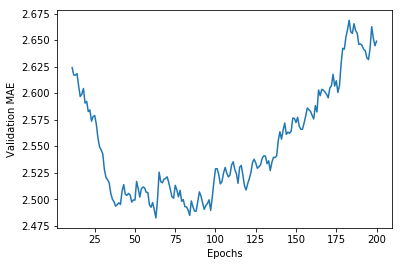

In [21]:
# To get more insights we drop the high-value first part of the results and rescale the rest
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point* (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(avarage_mae_history[10:])

plt.clf()
plt.plot(range(11, len(smooth_mae_history) + 11), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
# Conlusion is that there the network is overfiting after app 80 epochs